# Kirchner et al. 2019 - Figure S10
## Analysis of asparagine-generated motifs

Load libraries

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

Load human motif database

In [2]:
human_db = pd.read_csv('./human_db.csv')

### Motif abundance and frequency distribution

Create a list of protein identifier and screen for protein containing only asparagine-generated motifs

In [3]:
list_proteins = np.unique(human_db['ID'])

In [4]:
n_motif = list()
n_motif_counts = list()

for protein in tqdm(list_proteins):
    
    motifs, counts = np.unique(human_db[human_db['ID'] == protein]['motif_type'], return_counts=True)
       
    c = dict()
    for i, j in zip(motifs, counts):
        c[i] = j
    
    gene_name = str(np.unique(human_db[human_db['ID'] == protein]["Gene names"])[0]).split(' ')[0]
  
    if 'Canonical' not in motifs and 'Phosphorylation' not in motifs and 'Acetylation' not in motifs and 'Asparagine' in motifs:
        n_motif.append(gene_name)
        n_motif_counts.append(c['Asparagine'])

100%|██████████| 15969/15969 [12:22<00:00, 21.50it/s]


In [10]:
count = 0

for i in n_motif_counts: 
    if i == 1:
        count += 1

Create a pie chart of the overall abundance of asparagine-generated motifs

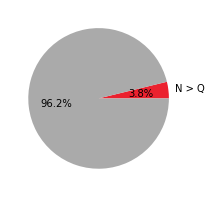

In [12]:
plt.figure(figsize=(3,3))

plt.pie([len(n_motif), 20165-len(n_motif)], 
        labels=['N > Q', ''], 
        explode=[0, 0], 
        colors=['#eb212e', '#aaaaaa'], autopct='%1.1f%%')

plt.tight_layout()
plt.savefig('./percent_proteome_nmotif.png', dpi=300)
plt.show()

Plot the distribution of number of motif per protein containing only asparagine-generated motifs

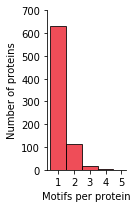

In [8]:
fig, ax = plt.subplots(figsize=(2,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.hist(n_motif_counts, bins=[1,2,3,4,5,6], align='left', width=1, edgecolor='k', facecolor='#EB212E', alpha=.8)

plt.xlim((0.3,5.3))
plt.xticks([1,2,3,4,5])
plt.ylabel('Number of proteins')
plt.xlabel('Motifs per protein')
plt.ylim(0,700)

plt.tight_layout()

plt.savefig('./plots/distribution.png', dpi=300)
plt.show()

### Subcellular localization of proteins containing asparagine-generated KFERQ-like motif

In [6]:
db = pd.read_table('./human_compartment_knowledge_full.tsv', 
                   names=['Ensembl', 'Gene', 'GO_term', 'Compartment',
                          'Database', 'Evidence_code', 'Confidence_score'])

In [7]:
# Select high confidence only (Score >=3)

db_hc = db[db['Confidence_score'] >= 3]

In [8]:
relevant_compartments = ["Cytoskeleton", 'Extracellular space', 'Peroxisome', 'Mitochondrion', 
                        'Nucleus', 'Cytosol', 'Endoplasmic reticulum', 'Endosome', 'Lysosome',
                        'Plasma membrane']

In [15]:
# Create a dict of the number of protein per compartment

prot_per_cmp = dict()

for c in relevant_compartments:
    prot_per_cmp[c] = np.unique(db_hc.loc[db_hc['Compartment'] == c, 'Gene'])

Results will be stored in dict to allow building of contengency tables and calculation of $\chi$ square statistics

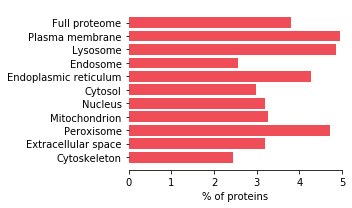

In [20]:
results_for_stats = dict()

fig, ax = plt.subplots(figsize=(5,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

for i,c in enumerate(relevant_compartments):
    
    total_in_compartment = len(prot_per_cmp[c])
    nb_n = 0
    
    for prot in prot_per_cmp[c]:
        if prot in n_motif:
            nb_n += 1
    
    results_for_stats[c] = {'n_motif': nb_n,
                            'other': total_in_compartment-nb_n,
                           'total_in_compartment': total_in_compartment
                           }
    
    percent_n = nb_n/total_in_compartment*100
    percent_other = 100 - percent_n
        
    plt.barh(y=i, width=percent_n, color='#EB212E', alpha=.8)
    
    
percent_total_proteome = 767/20165*100
plt.barh(y=len(relevant_compartments), width=percent_total_proteome, color='#EB212E', left=None, alpha=.8)

y_labels = relevant_compartments.copy()
y_labels.append('Full proteome')

plt.yticks(ticks=np.arange(len(relevant_compartments)+1), labels=y_labels)
plt.xlim(0, 5)

plt.xlabel('% of proteins')

plt.tight_layout()

plt.savefig('./compartment_n_only.png', dpi=300)

plt.show()

Export result table

In [ ]:
export = pd.DataFrame(results_for_stats)
export.to_csv('./results_compartments.csv')

### GO ontology analysis of proteins containing only asparagine-generated motifs

Load GO analysis results

In [7]:
go = pd.read_csv('./customGO_pz_reviewed_oneN.txt', sep='\t')
sorted_go = go.sort_values(by='combinedScore', ascending=False)

Create dataframe for graph and select the 10 highest combined score

In [11]:
export_for_graph = sorted_go[['in_category', 'n_category', 
                              'names', 'combinedScore']][:10]

export_for_graph = export_for_graph.sort_values(by='combinedScore')

Calculate the percent of proteins in that category having only asparagine-generated motifs

In [12]:
export_for_graph['percent'] = export_for_graph['in_category']/export_for_graph['n_category']*100

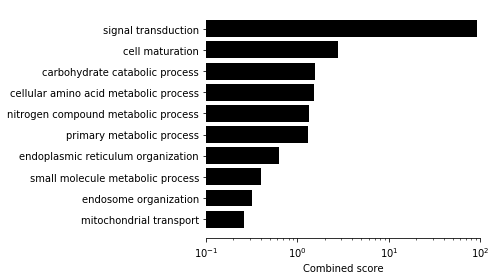

In [13]:
fig, ax = plt.subplots(figsize=(7,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

for i,j in enumerate(export_for_graph.index):
    plt.barh(i, width=export_for_graph.loc[j, 'combinedScore'], color='k')

plt.yticks(ticks=np.arange(len(export_for_graph['names'])), labels=export_for_graph['names'])
ax.set_xscale('log')

plt.xlim(0.1, 100)
plt.xlabel('Combined score')

plt.tight_layout()
plt.savefig('./plots/GO.png', dpi=300)

plt.show()

Export a table to manually add % on the figure

In [ ]:
export_for_graph.to_csv('./Go_n_motifs.csv')